# Z3 SAT Exercises

> Before trying to solve the exercises contained in this notebook, the reader is suggested to have gained experience with the tool through the `Tutorial.ipynb` notebook.

In [ ]:
!pip3 install z3-solver

In [1]:
from itertools import combinations
from z3 import *
import numpy as np

import matplotlib.pyplot as plt
import time
import itertools

## Useful contraints

In [2]:
def at_least_one(bool_vars):
    return Or(bool_vars)

# def at_most_one(bool_vars):
#     return [Not(And(pair[0], pair[1])) for pair in combinations(bool_vars, 2)]

# def exactly_one(bool_vars):
#     return at_most_one(bool_vars) + [at_least_one(bool_vars)]

def at_most_one(bool_vars):
    constraints = []
    n = len(bool_vars)
    s = [Bool(f"s_{i}") for i in range(n - 1)]
    constraints.append(Or(Not(bool_vars[0]), s[0]))
    constraints.append(Or(Not(bool_vars[n-1]), Not(s[n-2])))
    for i in range(1, n - 1):
        constraints.append(Or(Not(bool_vars[i]), s[i]))
        constraints.append(Or(Not(bool_vars[i]), Not(s[i-1])))
        constraints.append(Or(Not(s[i-1]), s[i]))
    return And(constraints)

def exactly_one(bool_vars):
    return And(at_least_one(bool_vars), at_most_one(bool_vars))

## VLSI

[1] https://web.telegram.org/cd003ba1-9c37-41f3-9be7-dceeb848b5e2

[2] https://sourceforge.net/p/potassco/mailman/attachment/1323943585.4102.431.camel@white.sevalidation.com/1/

#### Definition of the problem
**Input**: A set *R = {r1, . . . , rn}* of *n* rectangles. Each rectangle
*ri ∈ R* has a width *w_i* and a height *h_i* *(w_i, h_i ∈ N)*. A Strip of
width *W ∈ N*.

**Constraints**: Each rectangle cannot overlap with the others
and the edges of the strip and must be parallel to the horizontal
and the vertical axis.

**Question**: What is the minimum height such that the set of
rectangles can be packed in the given strip?

In [3]:
# VLSI instances
f = open('../instances/ins-1.txt', 'r')

instance = {
    'f_n': f.name.split('/')[2].split('.')[0].split('-')[1],
    'w': int(f.readline()),
    'n': int(f.readline()),
    'points': np.array([tuple(int(el) for el in x.split())\
                        for x in f.readlines()],\
                        dtype=[('w','i4'),('h','i4')])
}

print(instance)

#Toy case
# instance = {
#     'f_n': "toy",
#     'w': 9,
#     'n': 5,
#     'points' : np.array([(3,3),(2,4),(2,8),(3,9),(4,12)],\
#                        dtype=[('w','i4'),('h','i4')])
# }

{'f_n': '1', 'w': 8, 'n': 4, 'points': array([(3, 3), (3, 5), (5, 3), (5, 5)], dtype=[('w', '<i4'), ('h', '<i4')])}


In [4]:
def write_file(W, H, n, w, h, x, y, out_file):
    with open(out_file, 'w+') as f_out:
        f_out.write('{} {}\n'.format(W, H))
        f_out.write('{}\n'.format(n))

        for i in range(n):
            f_out.write('{} {} {} {}\n'.format(w[i], h[i], x[i], y[i]))

def show(l,lw=1.5):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))    
    dim_img_in=(np.sum([i[0] for i in l[1:]])+2*len(l)-4, max([i[1] for i in l[1:]]))
    img_in=np.zeros(shape=dim_img_in)
    pos=0
    c=0
    for i in l[1:]:
        c-=1
        i[2]-=1
        i[3]-=1
        img_in[pos:pos+i[0], 0:i[1]]=c
        pos+=i[0]+2
    
    ax1.imshow(np.transpose(img_in), cmap='terrain')
    ax1.set_xticks(np.arange(dim_img_in[0]+1)-0.5)
    ax1.set_xticklabels([])
    ax1.set_yticks(np.arange(dim_img_in[1]+1)-0.5)
    ax1.set_yticklabels([])
    ax1.set_xlim(-0.5,dim_img_in[0]-0.5)
    ax1.set_ylim(-0.5,dim_img_in[1]-0.5)
    ax1.grid(color='k', linestyle='-', linewidth=lw)
        
    dim_img_out=[l[0][0], l[0][1]+1]
    img_out=np.zeros(shape=dim_img_out)
    c=0
    
    for i in l[1:]:
        c-=1
        img_out[i[2]:i[2]+i[0],i[3]:i[3]+i[1]]=c        

    ax2.imshow(np.transpose(img_out), cmap='terrain')
    ax2.set_xticks(np.arange(dim_img_out[0]+1)-0.5)#,labels=[])
    ax2.set_xticklabels([])
    ax2.set_yticks(np.arange(dim_img_out[1]+1)-0.5)#,labels=[])
    ax2.set_yticklabels([])
    ax2.set_xlim(-0.5,dim_img_out[0]-0.5)
    ax2.set_ylim(-0.5,dim_img_out[1]-0.5)
    ax2.grid(color='k', linestyle='-', linewidth=lw)
    
    plt.show()

def converter_sat_coord(m, x, y, W, H, n):
    x_sol = []
    y_sol = [] 
    
    for i in range(n):
        j = 0
        while j < W:
            if m.evaluate(x[i][j]):
                x_sol.append(j)
                break
            j += 1

        j = 0
        while j < H:
            if m.evaluate(y[i][j]):
                y_sol.append(j)
                break
            j += 1

    return [x_sol, y_sol]

In [12]:
def vlsi_sat(instance):
    
    ''' VARIABLES '''
    
    w = instance['points']['w']
    h = instance['points']['h']
    
    W = instance['w']
    H = sum(h)
    n = instance['n']
    
    sum_a = sum([w_i*h_i for w_i,h_i in zip(w,h)])
    #rs = [[p[0],p[1]] for p in instance['points']]
        
    '''
    Massimo tra omin e altezza blocco con area massima
    
    Risultato * 2 + 1
    '''
    lb = int(sum_a/W)
    ub = int(2*max(
        max([[p[0],p[1]] for p in instance['points']],\
                         key=lambda p:p[0]*p[1])[1]
                     ,lb))+1
    print('lb', lb)
    print('ub', ub)
    
    H = lb
    while (lb < ub):
        s = Solver()

        '''
        Let x_i and y_i be integer variables such that the pair (x_i, y_i)
        represents the position of lower left coordinates of the rectangle
        ri in the strip.
        The domains of x_i and y_i are as folbows.
                            D(x_i) = {a ∈ N | 0 ≤ a ≤ W − w_i}
                            D(y_i) = {a ∈ N | 0 ≤ a ≤ H − h_i}
        '''
        
        x = [[Bool(f"x{i+1}_{x}") for x in range(W)] for i in range(n)]
        y = [[Bool(f"y{i+1}_{y}") for y in range(H)] for i in range(n)]
        
        
        #x_2 = [[Bool(f"x{i+1}_{x}") for x in range(W)] for i in range(n)]
        #y_2 = [[Bool(f"y{i+1}_{y}") for y in range(H)] for i in range(n)]
        
        for i in range(n): 
        # D(x_i) = {a ∈ N | 0 ≤ a ≤ W − w_i} -> W - w_i < a < W -> a = True
        # D(y_i) = {a ∈ N | 0 ≤ a ≤ H − h_i} -> H - h_i < a < H -> a = True
            for x_i in range(W - w[i], W):
                s.add(x[i][x_i])
            for y_i in range(H - h[i], H):
                s.add(y[i][y_i])
            # Order encoding constraints
            for x_i in range(W - w[i]):  
                s.add(Or(Not(x[i][x_i]), x[i][x_i + 1]))
            for y_i in range(H - h[i]):  
                s.add(Or(Not(y[i][y_i]), y[i][y_i + 1]))
            
        '''
        Let r_i, r_j ∈ R(i != j) be two rectangles. We use two
        kinds of propositional variables: lr_i,j and ud_i,j.
        lr_i,j is true if r_i are placed at the left to the r_j.
        ud_i,j is true if r_i are placed at the downward to the r_j.

        For each rectangles r_i,r_j (i < j), we have the non-overlapping
        constraints:
                            lr_i,j ∨ lr_j,i ∨ ud_i,j ∨ ud_j,i
                                ¬lr_i,j ∨ (x_i + w_i ≤ x_j)
                                ¬lr_j,i ∨ (x_j + w_j ≤ x_i)
                                ¬ud_i,j ∨ (y_i + h_i ≤ y_j)
                                ¬ud_j,i ∨ (y_j + h_j ≤ y_i)
        The parts between parentheses are encoded into SAT by using order
        encoding.
        '''
        lr = [[Bool(f"r{i+1}_lr_r{j+1}") if j!=i else 0 for j in range(n)] for i in range(n)]
        ud = [[Bool(f"r{i+1}_ud_r{j+1}") if i!=j else 0 for j in range(n)] for i in range(n)]
  

        '''
        PER FLIPPARE:
        
        Se i != j 
            ( (Not(flip[i]) & Not(flip[j]) & Base) V 
            ( ((flip[i]) & Not(flip[j])) & Base con x,y invertiti a i) V
            ( (Not(flip[i]) & (flip[j])) & Base con x,y invertiti a j) V
            ( (Not(flip[i]) & Not(flip[j])) & Base con x,y invertiti a entrambi) 
        '''
        
        #flip = [Bool(f"flip{i+1}") for i in range(n)]

        for i in range(n):
            for j in range(n):
                if i < j:
                    s.add(Or(lr[i][j], lr[j][i], ud[i][j], ud[j][i]))
                    
                if i != j:
                    # WIDTH
                    s.add(Or(
                        Not(lr[i][j]),
                        Not(x[j][w[i] - 1])
                    )) # left(r_i,r_j) -> x_j > w_i, lower bound for x_j

                    for k in range(0,W-w[i]):
                        s.add(Or(
                               Not(lr[i][j]),
                               x[i][k],
                               Not(x[j][k+w[i]])
                             )) #for any k: left(r_i,r_j) -> (x_i < k v ! x_j < k + w_i)

                    # HEIGHT
                    s.add(Or(
                           Not(ud[i][j]),
                           Not(y[j][h[i]-1])
                         )) #under(r_i,r_j)-> y_j > h_i, lower bound for y_j

                    for k in range(0,H-h[i]):
                        s.add(Or(
                               Not(ud[i][j]),
                               y[i][k],
                               Not(y[j][k+h[i]])
                             )) #for any k: under(r_i,r_j) -> (y_j <= k + h_i -> y_i <= k)

        if s.check() == sat:
            ub = H
            print('SAT:ub->',ub)
        else:
            lb = H + 1
            print('UNSAT:lb->',lb)
            
        H =  int((lb+ub)/2)
        
        '''
        N.B. We use 'Bisection Method' to optimize the solution:
            while lb < ub
                o := (lb + ub)/2;
                resubt := Ψ ∪ {ph_o};
                if resubt is SAT
                    then ub := o;
                    else lb := o + 1;
            end while
        '''
    
    return s.model(), x, y, H

In [13]:
%%time

for ins in range(1,3):
    f = open('../instances/ins-' + str(ins) + '.txt', 'r')
    print('===============================================')
    instance = {
        'f_n': f.name.split('/')[2].split('.')[0].split('-')[1],
        'w': int(f.readline()),
        'n': int(f.readline()),
        'points': np.array([tuple(int(el) for el in x.split())\
                            for x in f.readlines()],\
                            dtype=[('w','i4'),('h','i4')])
    }
    
    s_time = time.time()
    m,x,y,H = vlsi_sat(instance)
    e_time = time.time() - s_time
    
    print(f'Instance[{ins}]: {round(e_time,3)} s')
    cx, cy = converter_sat_coord(m, x, y, instance['w'],\
                                 sum(instance['points']['h']), instance['n'])

    write_file(instance['w'], H, instance['n'], instance['points']['w'],\
               instance['points']['h'], cx, cy, './outputs_2/out_' + instance['f_n'] +'.txt')
    print('===============================================')
    print('\n')

lb 8
ub 17
SAT:ub-> 8
Instance[1]: 0.045 s


lb 9
ub 19
SAT:ub-> 9
Instance[2]: 0.067 s


Wall time: 118 ms


In [20]:
print(cx, cy)

[5, 0, 0, 3] [0, 3, 0, 3]


[(3, 3) (3, 5) (5, 3) (5, 5)]
[(1, 6), (6, 1), (4, 6), (1, 1)]


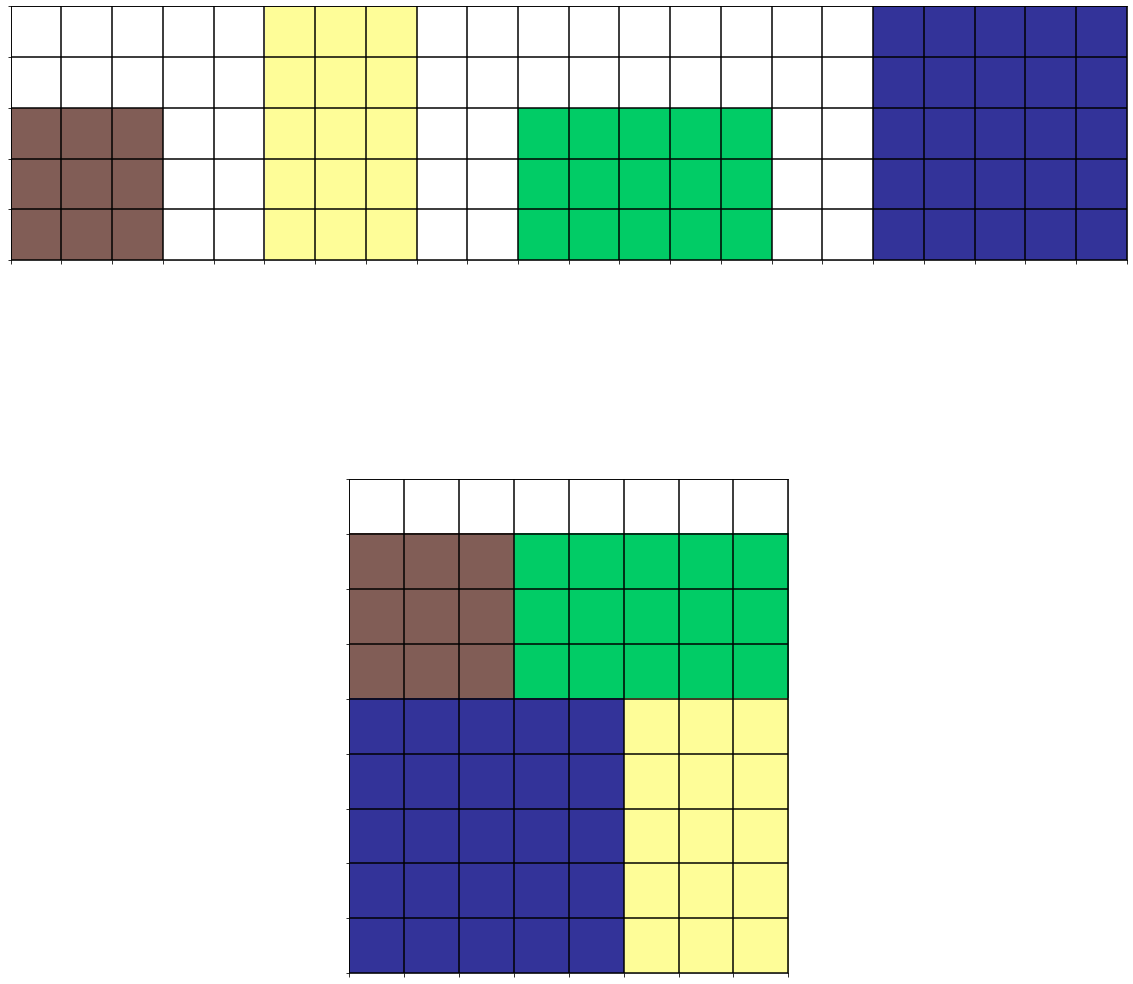

In [11]:
for ins in range(1,2):
    with open('./outputs_2/out_' + str(ins) +'.txt', "r") as file:  # Use file to refer to the file object
        first_line = file.readline().strip().split(" ")

        width = int(first_line[0])
        height = int(first_line[1])

        n = int(file.readline().strip())

        # Read all the remaining lines which contains the horizontal and vertical dimension of the i-th circuit
        # and its bottom left corner coordinate
        remaining_lines = file.readlines()

        # To remove \n
        remaining_lines = [line.strip() for line in remaining_lines if line.strip()]

        circuits = []
        solution = {'corners': []}

        for i in range(n):
            line = remaining_lines[i]
            line = line.split()
            circuits.append((int(line[0]), int(line[1])))
            solution['corners'].append((int(line[2]), int(line[3])))

    # Solution
    sol = {
        "w": width,
        "h": height,
        "n": n,
        "points" : np.array(circuits,\
                            dtype=[('w','i4'),('h','i4')])
    }


    print(sol['points'])
    print([(x+1,y+1) for (x,y) in solution['corners']])

    a = sol['points']
    b = solution['corners']

    l = [[sol['w'], sol['h']]]
    for i in range(len(a)):
        l.append([a[i][0],a[i][1],b[i][0]+1,b[i][1]+1])

    #print(l)
    show(l)